In [270]:
import pandas as pd
from geographiclib.geodesic import Geodesic
import geopandas
from geographiclib.geodesic import Geodesic
import math
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from branca.element import Figure
from IPython.display import HTML, display

geod = Geodesic.WGS84 

data = 'obc_tanker_cargo.csv'
df = pd.read_csv(data)
df.shape

(131308, 23)

In [271]:
df['BEAM'] = df['DIM_PORT'] + df['DIM_STARBOARD']
df['LENGTH'] = df['DIM_BOW'] + df['DIM_STERN']
df = df[df['BEAM'] > 0]
df = df[df['LENGTH'] > 0]
df = df[df['DRAUGHT'] > 0]
df.shape

(127770, 25)

In [272]:
df = df[df['NAV_STATUS'] == 0]
df.shape

(125355, 25)

In [273]:
df = df[df['SPEED_KNOTS'] > 3]
df.shape

(124600, 25)

In [274]:
df['MMSI'].nunique()

3522

In [275]:
df['PERIOD'] = pd.to_datetime(df['PERIOD'])
df['DATE'] = df['PERIOD'].dt.date
df['TIME'] = df['PERIOD'].dt.time
df['CHANNEL_SIDE'] = ['Northwestbound' if x > 200 else 'Southeastbound' for x in df['COG_DEG']]

In [276]:
df = df.sort_values(['MMSI', 'PERIOD'])
df['time_diff'] = (df.groupby('MMSI')['PERIOD'].diff().dt.total_seconds())

threshold = 3 * 3600
df['new_voyage'] = (df['time_diff'] > threshold)
df['voyage_id'] = (df.groupby('MMSI')['new_voyage'].cumsum()+1)
df

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,MMSI_COUNTRY_CD,RECEIVER,BEAM,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id
116677,1,205042000,DELOS,9877767.0,ONKR,22.736758,-78.616947,2023-06-04 14:00:00,13.0,110.0,...,BE,rEV02,60,336,2023-06-04,14:00:00,Southeastbound,NaN,False,1
116686,1,205042000,DELOS,9877767.0,ONKR,22.707576,-78.536280,2023-06-04 14:20:00,13.1,111.2,...,BE,rEV02,60,336,2023-06-04,14:20:00,Southeastbound,1200.0,False,1
116687,1,205042000,DELOS,9877767.0,ONKR,22.705818,-78.531350,2023-06-04 14:25:00,13.1,111.3,...,BE,rEV02,60,336,2023-06-04,14:25:00,Southeastbound,300.0,False,1
116698,1,205042000,DELOS,9877767.0,ONKR,22.666790,-78.419349,2023-06-04 14:55:00,13.3,110.4,...,BE,rEV02,60,336,2023-06-04,14:55:00,Southeastbound,1800.0,False,1
116703,1,205042000,DELOS,9877767.0,ONKR,22.654898,-78.384704,2023-06-04 15:05:00,13.4,110.2,...,BE,rEV02,60,336,2023-06-04,15:05:00,Southeastbound,600.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102529,1,720202000,INTL VICTORY,8977766.0,CPA3027,23.360848,-78.953454,2024-10-28 21:30:00,7.0,342.5,...,BO,NaN,12,33,2024-10-28,21:30:00,Northwestbound,26100.0,True,25
102530,1,720202000,INTL VICTORY,8977766.0,CPA3027,23.364144,-78.954727,2024-10-28 21:35:00,6.9,346.9,...,BO,NaN,12,33,2024-10-28,21:35:00,Northwestbound,300.0,False,25
102854,1,720202000,INTL VICTORY,8977766.0,CPA3027,22.251636,-77.465667,2024-11-15 21:30:00,6.3,130.8,...,BO,NaN,12,33,2024-11-15,21:30:00,Southeastbound,1554900.0,True,26
102859,1,720202000,INTL VICTORY,8977766.0,CPA3027,22.009253,-77.023147,2024-11-16 02:10:00,6.3,116.5,...,BO,NaN,12,33,2024-11-16,02:10:00,Southeastbound,16800.0,True,27


In [277]:
ping_counts = (df.groupby(['MMSI', 'voyage_id']).size().reset_index(name='num_pings'))
ping_counts.sort_values(['num_pings'])

,MMSI,voyage_id,num_pings
30,205681000,10,1
25,205681000,5,1
23,205681000,3,1
15992,720202000,24,1
9548,477162100,1,1
...,...,...,...
13667,636020073,1,148
13145,636016672,1,151
12354,563758000,7,153
949,219466000,2,158


In [278]:
sus_vessel = df[df['MMSI']==353054000]
sus_vessel = sus_vessel[sus_vessel['voyage_id']==4]
sus_vessel

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,MMSI_COUNTRY_CD,RECEIVER,BEAM,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id
49417,1,353054000,BALSA 94,9800855.0,H9TG,22.980534,-79.336711,2024-02-24 00:05:00,11.3,110.9,...,PA,rORBCOMM999,19,106,2024-02-24,00:05:00,Southeastbound,7666800.0,True,4
49418,1,353054000,BALSA 94,9800855.0,H9TG,22.974169,-79.318125,2024-02-24 00:10:00,11.2,109.9,...,PA,rORBCOMM999,19,106,2024-02-24,00:10:00,Southeastbound,300.0,False,4
49419,1,353054000,BALSA 94,9800855.0,H9TG,22.968548,-79.301316,2024-02-24 00:15:00,11.3,110.4,...,PA,rORBCOMM999,19,106,2024-02-24,00:15:00,Southeastbound,300.0,False,4
49421,1,353054000,BALSA 94,9800855.0,H9TG,22.963040,-79.283819,2024-02-24 00:20:00,11.3,108.8,...,PA,rORBCOMM999,19,106,2024-02-24,00:20:00,Southeastbound,300.0,False,4
49422,1,353054000,BALSA 94,9800855.0,H9TG,22.957961,-79.267942,2024-02-24 00:25:00,11.3,109.5,...,PA,rORBCOMM999,19,106,2024-02-24,00:25:00,Southeastbound,300.0,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50763,1,353054000,BALSA 94,9800855.0,H9TG,21.716168,-76.892965,2024-02-24 14:00:00,11.2,115.9,...,PA,rORBCOMM999,19,106,2024-02-24,14:00:00,Southeastbound,300.0,False,4
50778,1,353054000,BALSA 94,9800855.0,H9TG,21.708614,-76.876192,2024-02-24 14:05:00,11.1,116.1,...,PA,rORBCOMM999,19,106,2024-02-24,14:05:00,Southeastbound,300.0,False,4
50781,1,353054000,BALSA 94,9800855.0,H9TG,21.701391,-76.860013,2024-02-24 14:10:00,11.1,115.4,...,PA,rORBCOMM999,19,106,2024-02-24,14:10:00,Southeastbound,300.0,False,4
50797,1,353054000,BALSA 94,9800855.0,H9TG,21.694136,-76.843530,2024-02-24 14:15:00,11.0,115.3,...,PA,rORBCOMM999,19,106,2024-02-24,14:15:00,Southeastbound,300.0,False,4


In [279]:
data = pd.read_csv('obc_boundaries_plus.csv')
from shapely.geometry import Point
from shapely.geometry import Polygon
data = data[data['Line']!='Middle']
data['geometry'] = data.apply(lambda x: (float(x.Long), float(x.Lat)), axis=1)

channel_coords = list(data['geometry'])
channel_coords_reorder = [channel_coords[0], channel_coords[1], channel_coords[2], channel_coords[3], channel_coords[-1], channel_coords[-2], channel_coords[-3], channel_coords[-4]]
channel_polygon = Polygon(channel_coords_reorder)
geo_df_channel = geopandas.GeoDataFrame(geometry=[channel_polygon], crs='EPSG:4326')

In [280]:
geo_df_sus_vessel = geopandas.GeoDataFrame(sus_vessel, geometry=geopandas.points_from_xy(sus_vessel['LON_AVG'], sus_vessel['LAT_AVG']), crs='EPSG:4326')

In [281]:
def where_is_vessel(LAT_AVG, LON_AVG, BOOL):
    if BOOL == True:
        answer = 'in channel'
    elif LON_AVG < -78.72296667:
        answer = 'west'
    elif LON_AVG > -77.49385:
        answer = 'east'
    elif LAT_AVG > 22.84101667:
        answer = 'north'
    elif LAT_AVG < 22.12445:
        answer = 'south'
    else:
        answer = 'other'
    return answer
    

In [282]:
geo_df_sus_vessel['in_channel'] = geo_df_sus_vessel.within(channel_polygon)
geo_df_sus_vessel['location'] = geo_df_sus_vessel.apply(lambda x: where_is_vessel(x.LAT_AVG, x.LON_AVG, x.in_channel), axis=1)
geo_df_sus_vessel.head()

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id,geometry,in_channel,location
49417,1,353054000,BALSA 94,9800855.0,H9TG,22.980534,-79.336711,2024-02-24 00:05:00,11.3,110.9,...,106,2024-02-24,00:05:00,Southeastbound,7666800.0,True,4,POINT (-79.33671 22.98053),False,west
49418,1,353054000,BALSA 94,9800855.0,H9TG,22.974169,-79.318125,2024-02-24 00:10:00,11.2,109.9,...,106,2024-02-24,00:10:00,Southeastbound,300.0,False,4,POINT (-79.31812 22.97417),False,west
49419,1,353054000,BALSA 94,9800855.0,H9TG,22.968548,-79.301316,2024-02-24 00:15:00,11.3,110.4,...,106,2024-02-24,00:15:00,Southeastbound,300.0,False,4,POINT (-79.30132 22.96855),False,west
49421,1,353054000,BALSA 94,9800855.0,H9TG,22.963040,-79.283819,2024-02-24 00:20:00,11.3,108.8,...,106,2024-02-24,00:20:00,Southeastbound,300.0,False,4,POINT (-79.28382 22.96304),False,west
49422,1,353054000,BALSA 94,9800855.0,H9TG,22.957961,-79.267942,2024-02-24 00:25:00,11.3,109.5,...,106,2024-02-24,00:25:00,Southeastbound,300.0,False,4,POINT (-79.26794 22.95796),False,west


In [283]:
df_unique_full = df.drop_duplicates(subset='MMSI').copy()
df_unique_full['first_three'] = (df_unique_full['MMSI'].astype(str).str[:3].astype(int))

In [284]:
df_unique_full.sort_values(['first_three'])
print(df_unique_full['first_three'].value_counts())

first_three
538    685
636    596
477    198
563    191
352    136
      ... 
622      1
642      1
632      1
626      1
668      1
Name: count, Length: 105, dtype: int64


In [285]:
geo_df_sus_vessel_clean = geo_df_sus_vessel['geometry']
geo_df_sus_vessel['in_channel'].value_counts()


in_channel
False    86
True     81
Name: count, dtype: int64

In [286]:
my_map = folium.Map(location=[22.5, -77.8], zoom_start=11)
folium.GeoJson(geo_df_channel).add_to(my_map)
folium.GeoJson(geo_df_sus_vessel_clean).add_to(my_map)
my_map

<Axes: >

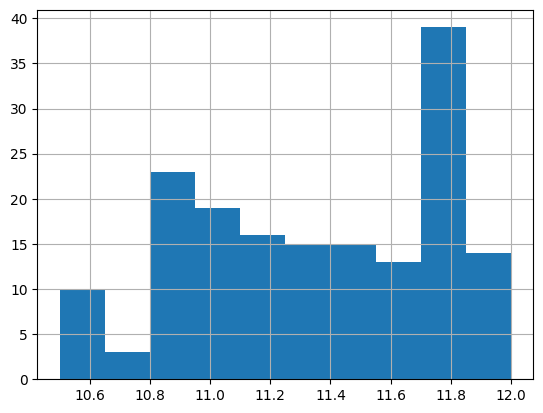

In [287]:
geo_df_sus_vessel['SPEED_KNOTS'].hist()

In [288]:
geo_df_vessels = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['LON_AVG'], df['LAT_AVG']), crs='EPSG:4326')
geo_df_vessels['in_channel'] = geo_df_vessels.within(channel_polygon)
geo_df_vessels['location'] = geo_df_vessels.apply(lambda x: where_is_vessel(x.LAT_AVG, x.LON_AVG, x.in_channel), axis=1)
geo_df_vessels.head()

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id,geometry,in_channel,location
116677,1,205042000,DELOS,9877767.0,ONKR,22.736758,-78.616947,2023-06-04 14:00:00,13.0,110.0,...,336,2023-06-04,14:00:00,Southeastbound,NaN,False,1,POINT (-78.61695 22.73676),True,in channel
116686,1,205042000,DELOS,9877767.0,ONKR,22.707576,-78.536280,2023-06-04 14:20:00,13.1,111.2,...,336,2023-06-04,14:20:00,Southeastbound,1200.0,False,1,POINT (-78.53628 22.70758),True,in channel
116687,1,205042000,DELOS,9877767.0,ONKR,22.705818,-78.531350,2023-06-04 14:25:00,13.1,111.3,...,336,2023-06-04,14:25:00,Southeastbound,300.0,False,1,POINT (-78.53135 22.70582),True,in channel
116698,1,205042000,DELOS,9877767.0,ONKR,22.666790,-78.419349,2023-06-04 14:55:00,13.3,110.4,...,336,2023-06-04,14:55:00,Southeastbound,1800.0,False,1,POINT (-78.41935 22.66679),True,in channel
116703,1,205042000,DELOS,9877767.0,ONKR,22.654898,-78.384704,2023-06-04 15:05:00,13.4,110.2,...,336,2023-06-04,15:05:00,Southeastbound,600.0,False,1,POINT (-78.3847 22.6549),True,in channel


In [289]:
geo_df_vessels['location'].value_counts()

location
in channel    61513
east          38325
west          24394
north           298
other            57
south            13
Name: count, dtype: int64

In [290]:
weird_vessels = geo_df_vessels[geo_df_vessels['location']!='in channel']
weird_vessels = weird_vessels[geo_df_vessels['location']!='east']
weird_vessels = weird_vessels[geo_df_vessels['location']!='west']

c:\Users\LAKwon\anaconda3\envs\capstone\Lib\site-packages\geopandas\geodataframe.py:1891: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\LAKwon\anaconda3\envs\capstone\Lib\site-packages\geopandas\geodataframe.py:1891: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [291]:
weird_vessels.head()
weird_vessels_clean = weird_vessels[['geometry']]

In [292]:
m = folium.Map(location=[22.5, -77.8], zoom_start=11)
weird_vessels["PERIOD"] = weird_vessels['PERIOD'].astype(str)
folium.GeoJson(geo_df_channel).add_to(m)
folium.GeoJson(weird_vessels_clean).add_to(m)
m

In [293]:
df_unique = weird_vessels.drop_duplicates(subset='MMSI').copy()
df_unique['first_three'] = (df_unique['MMSI'].astype(str).str[:3].astype(int))

In [294]:
df_unique.head()

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id,geometry,in_channel,location,first_three
112861,1,255806086,SONDERBORG,9454242.0,CQIW4,22.108671,-77.500992,2023-05-21 19:40:00,14.4,131.8,...,2023-05-21,19:40:00,Southeastbound,900.0,False,10,POINT (-77.50099 22.10867),False,south,255
96398,1,255915644,SEABOARD GARDENIA,9673630.0,CQ2102,22.900053,-78.710780,2025-06-03 02:50:00,17.9,328.8,...,2025-06-03,02:50:00,Northwestbound,2700.0,False,27,POINT (-78.71078 22.90005),False,north,255
20938,1,271048264,KPS GULTEKIN BEY,9002049.0,TCA6188,22.014700,-77.520189,2023-03-08 18:20:00,6.2,150.2,...,2023-03-08,18:20:00,Southeastbound,3600.0,False,2,POINT (-77.52019 22.0147),False,south,271
14533,1,304813000,SINAA,9081318.0,V2IG4,22.920255,-78.707775,2023-02-15 14:40:00,16.3,324.0,...,2023-02-15,14:40:00,Northwestbound,7800.0,False,6,POINT (-78.70778 22.92026),False,north,304
2692,1,304941000,DENEB,9344241.0,V2BW1,22.930755,-78.692354,2023-04-08 19:20:00,14.0,325.9,...,2023-04-08,19:20:00,Northwestbound,300.0,False,10,POINT (-78.69235 22.93076),False,north,304


In [295]:
df.columns

Index(['MSG_TYPE', 'MMSI', 'NAME', 'IMO_NUMBER', 'CALL_SIGN', 'LAT_AVG',
       'LON_AVG', 'PERIOD', 'SPEED_KNOTS', 'COG_DEG', 'HEADING_DEG',
       'NAV_STATUS', 'NAV_SENSOR', 'SHIP_AND_CARGO_TYPE', 'DRAUGHT',
       'DRAUGHT.1', 'DIM_BOW', 'DIM_STERN', 'DIM_PORT', 'DIM_STARBOARD',
       'DESTINATION', 'MMSI_COUNTRY_CD', 'RECEIVER', 'BEAM', 'LENGTH', 'DATE',
       'TIME', 'CHANNEL_SIDE', 'time_diff', 'new_voyage', 'voyage_id'],
      dtype='object')

In [296]:
df_routes = df[['MMSI', 'LAT_AVG', 'LON_AVG', 'DATE', 'TIME', 'SPEED_KNOTS', 'COG_DEG', 'HEADING_DEG']]
df_routes['DATETIME'] = pd.to_datetime(df_routes['DATE'].astype(str) + ' ' + df_routes['TIME'].astype(str))
df_routes['in_channel'] = geo_df_vessels.within(channel_polygon)
out_of_channel = df_routes[df_routes['in_channel']==False].index
df_routes.drop(out_of_channel, inplace=True)

df_routes.drop(columns=['TIME', 'DATE'])


C:\Users\LAKwon\AppData\Local\Temp\ipykernel_9896\1493946565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_routes['DATETIME'] = pd.to_datetime(df_routes['DATE'].astype(str) + ' ' + df_routes['TIME'].astype(str))
C:\Users\LAKwon\AppData\Local\Temp\ipykernel_9896\1493946565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_routes['in_channel'] = geo_df_vessels.within(channel_polygon)
C:\Users\LAKwon\AppData\Local\Temp\ipykernel_9896\1493946565.py:5: SettingWithCopyWarning: 
A value is trying to 

,MMSI,LAT_AVG,LON_AVG,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME,in_channel
116677,205042000,22.736758,-78.616947,13.0,110.0,111.0,2023-06-04 14:00:00,True
116686,205042000,22.707576,-78.536280,13.1,111.2,112.0,2023-06-04 14:20:00,True
116687,205042000,22.705818,-78.531350,13.1,111.3,112.0,2023-06-04 14:25:00,True
116698,205042000,22.666790,-78.419349,13.3,110.4,111.0,2023-06-04 14:55:00,True
116703,205042000,22.654898,-78.384704,13.4,110.2,111.0,2023-06-04 15:05:00,True
...,...,...,...,...,...,...,...,...
101927,720202000,22.341019,-77.682020,5.8,122.5,NaN,2024-10-15 08:30:00,True
101928,720202000,22.340283,-77.680780,5.8,122.4,NaN,2024-10-15 08:35:00,True
101933,720202000,22.301945,-77.614594,5.7,124.2,NaN,2024-10-15 09:20:00,True
102513,720202000,22.730453,-78.362087,7.3,299.6,NaN,2024-10-28 14:15:00,True


In [297]:
df_routes.dtypes

MMSI                    int64
LAT_AVG               float64
LON_AVG               float64
DATE                   object
TIME                   object
SPEED_KNOTS           float64
COG_DEG               float64
HEADING_DEG           float64
DATETIME       datetime64[ns]
in_channel               bool
dtype: object

In [298]:
df_routes.sort_values('MMSI')

,MMSI,LAT_AVG,LON_AVG,DATE,TIME,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME,in_channel
116677,205042000,22.736758,-78.616947,2023-06-04,14:00:00,13.0,110.0,111.0,2023-06-04 14:00:00,True
116686,205042000,22.707576,-78.536280,2023-06-04,14:20:00,13.1,111.2,112.0,2023-06-04 14:20:00,True
116687,205042000,22.705818,-78.531350,2023-06-04,14:25:00,13.1,111.3,112.0,2023-06-04 14:25:00,True
116698,205042000,22.666790,-78.419349,2023-06-04,14:55:00,13.3,110.4,111.0,2023-06-04 14:55:00,True
116703,205042000,22.654898,-78.384704,2023-06-04,15:05:00,13.4,110.2,111.0,2023-06-04 15:05:00,True
...,...,...,...,...,...,...,...,...,...,...
101927,720202000,22.341019,-77.682020,2024-10-15,08:30:00,5.8,122.5,NaN,2024-10-15 08:30:00,True
101928,720202000,22.340283,-77.680780,2024-10-15,08:35:00,5.8,122.4,NaN,2024-10-15 08:35:00,True
101933,720202000,22.301945,-77.614594,2024-10-15,09:20:00,5.7,124.2,NaN,2024-10-15 09:20:00,True
102513,720202000,22.730453,-78.362087,2024-10-28,14:15:00,7.3,299.6,NaN,2024-10-28 14:15:00,True


In [299]:
df_routes['MMSI'].nunique()

3132

In [300]:
first_vessel = df_routes['MMSI'][0]

df_first_vessel = df_routes[df_routes['MMSI'] == first_vessel]
df_first_vessel = df_first_vessel.sort_values(['DATETIME'])
df_first_vessel['DELTA_SECONDS'] = df_first_vessel['DATETIME'].diff().dt.total_seconds()
df_first_vessel.head()

time_cutoff = 3*60*60 # 3 hrs to seconds
df_first_vessel['NEW_TRACK_CHECK'] = ((df_first_vessel['DELTA_SECONDS'] >= time_cutoff))
df_first_vessel['TRACK_COUNT'] = df_first_vessel['NEW_TRACK_CHECK'].cumsum()
df_first_vessel['TRACK_COUNT'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [301]:

# ---- config ----
TRACK_COL = "TRACK_COUNT"
LAT_COL   = "LAT_AVG"
LON_COL   = "LON_AVG"
TIME_COL  = "DATETIME"
TRACKS_PER_MAP = 5

# ---- prep ----
df_first_vessel = df_first_vessel.sort_values([TRACK_COL, TIME_COL]).dropna(subset=[LAT_COL, LON_COL])

tracks = sorted(df_first_vessel[TRACK_COL].unique())
n_tracks = len(tracks)

# A lot of distinct colors (good for 50-80 tracks)
cmap = cm.get_cmap("hsv", n_tracks)
track_colors = {t: mcolors.to_hex(cmap(i)) for i, t in enumerate(tracks)}

# ---- helper to build one mini map from a list of tracks ----
def build_map(track_list):
    sub = df_first_vessel[df_first_vessel[TRACK_COL].isin(track_list)].copy()
    center = [sub[LAT_COL].mean(), sub[LON_COL].mean()]

    m = folium.Map(location=[22.5, -77.8], zoom_start=9)

    for t in track_list:
        g = sub[sub[TRACK_COL] == t].sort_values(TIME_COL)
        coords = list(zip(g[LAT_COL].to_list(), g[LON_COL].to_list()))
        if len(coords) < 2:
            continue

        folium.PolyLine(
            locations=coords,
            color=track_colors[t],
            weight=4,
            opacity=0.9,
            tooltip=f"Track {t} (n={len(g)})"
        ).add_to(m)

        # start/end markers (optional)
        folium.CircleMarker(coords[0], radius=3, fill=True, tooltip=f"Start {t}").add_to(m)
        folium.CircleMarker(coords[-1], radius=3, fill=True, tooltip=f"End {t}").add_to(m)

    # Add a title inside the map
    title = f"Tracks: {track_list[0]}–{track_list[-1]}" if len(track_list) > 1 else f"Track: {track_list[0]}"
    folium.map.Marker(
        center,
        icon=folium.DivIcon(html=f"""<div style="font-size:14px;font-weight:600;background:rgba(255,255,255,0.8);
                                      padding:4px 8px;border-radius:6px;border:1px solid #ccc;">
                                      {title}
                                     </div>""")
    ).add_to(m)

    return m

# ---- build maps in batches of 5 ----
batches = [tracks[i:i+TRACKS_PER_MAP] for i in range(0, n_tracks, TRACKS_PER_MAP)]
maps = [build_map(batch) for batch in batches]

# ---- render them as a responsive grid in the notebook ----
# (Folium maps are HTML iframes; we embed each one)
map_html_blocks = []
for m in maps:
    html = m._repr_html_()  # iframe HTML
    map_html_blocks.append(f'<div class="cell">{html}</div>')

grid_html = f"""
<style>
.grid {{
  display: grid;
  grid-template-columns: repeat(2, minmax(420px, 1fr));
  gap: 14px;
  align-items: start;
}}
.cell iframe {{
  width: 100% !important;
  height: 420px !important;
  border-radius: 10px;
}}
</style>
<div class="grid">
  {''.join(map_html_blocks)}
</div>
"""

display(HTML(grid_html))

C:\Users\LAKwon\AppData\Local\Temp\ipykernel_9896\604427500.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("hsv", n_tracks)


In [302]:
# ---- helper to build one mini map from a list of tracks ----
def build_map(track_list):
    sub = df_first_vessel[df_first_vessel[TRACK_COL].isin(track_list)].copy()
    center = [sub[LAT_COL].mean(), sub[LON_COL].mean()]

    m = folium.Map(location=[22.5, -77.8], zoom_start=9)

    for t in track_list:
        g = sub[sub[TRACK_COL] == t]

        color = track_colors[t]

        for _, row in g.iterrows():
            folium.CircleMarker(
                location=[row[LAT_COL], row[LON_COL]],
                radius=3,
                color=color,
                fill=True,
                fill_opacity=0.8,
                tooltip=f"Track {t}<br>{row[TIME_COL]}"
            ).add_to(m)


    # Add a title inside the map
    title = f"Tracks: {track_list[0]}–{track_list[-1]}" if len(track_list) > 1 else f"Track: {track_list[0]}"
    folium.map.Marker(
        center,
        icon=folium.DivIcon(html=f"""<div style="font-size:14px;font-weight:600;background:rgba(255,255,255,0.8);
                                      padding:4px 8px;border-radius:6px;border:1px solid #ccc;">
                                      {title}
                                     </div>""")
    ).add_to(m)

    return m

# ---- build maps in batches of 5 ----
batches = [tracks[i:i+TRACKS_PER_MAP] for i in range(0, n_tracks, TRACKS_PER_MAP)]
maps = [build_map(batch) for batch in batches]

# ---- render them as a responsive grid in the notebook ----
# (Folium maps are HTML iframes; we embed each one)
map_html_blocks = []
for m in maps:
    html = m._repr_html_()  # iframe HTML
    map_html_blocks.append(f'<div class="cell">{html}</div>')

grid_html = f"""
<style>
.grid {{
  display: grid;
  grid-template-columns: repeat(2, minmax(420px, 1fr));
  gap: 14px;
  align-items: start;
}}
.cell iframe {{
  width: 100% !important;
  height: 420px !important;
  border-radius: 10px;
}}
</style>
<div class="grid">
  {''.join(map_html_blocks)}
</div>
"""

display(HTML(grid_html))

In [303]:
df_routes = df_routes.sort_values(['DATETIME'])
df_routes['DELTA_SECONDS'] = df_routes['DATETIME'].diff().dt.total_seconds()
df_routes.head()

time_cutoff = 3*60*60 # 3 hrs to seconds
df_routes = df_routes.sort_values("MMSI")
df_routes['NEW_TRACK_CHECK'] = ((df_routes['DELTA_SECONDS'] >= time_cutoff))
df_routes['TRACK_COUNT'] = df_routes['NEW_TRACK_CHECK'].cumsum()
df_routes['TRACK_COUNT'].unique()

array([   0,    1,    2, ..., 1640, 1641, 1642], shape=(1643,))

In [304]:
def in_box(df, lat_col, lon_col, box):
    return (
        df[lat_col].between(box["lat_low"], box["lat_high"], inclusive="both")
        & df[lon_col].between(box["lon_low"], box["lon_high"], inclusive="both")
    )

def filter_tracks_start_end_in_A_B(
    df,
    mmsi_col="MMSI",
    track_col="TRACK_COUNT",
    time_col="DATETIME",
    lat_col="LAT_AVG",
    lon_col="LON_AVG",
    boxA=None,
    boxB=None,
):
    # sort so "first" and "last" are true endpoints
    d = df.sort_values([mmsi_col, track_col, time_col]).copy()

    # first/last row per MMSI+track
    first = d.groupby([mmsi_col, track_col], as_index=True).head(1)
    last  = d.groupby([mmsi_col, track_col], as_index=True).tail(1)

    # endpoint-in-box tests
    first_in_A = in_box(first, lat_col, lon_col, boxA).to_numpy()
    first_in_B = in_box(first, lat_col, lon_col, boxB).to_numpy()
    last_in_A  = in_box(last,  lat_col, lon_col, boxA).to_numpy()
    last_in_B  = in_box(last,  lat_col, lon_col, boxB).to_numpy()

    # keep if endpoints are (A,B) in either order
    keep_mask = (first_in_A & last_in_B) | (first_in_B & last_in_A)

    keep_pairs = first.loc[keep_mask, [mmsi_col, track_col]].set_index([mmsi_col, track_col]).index

    kept_df = (
        d.set_index([mmsi_col, track_col])
         .loc[keep_pairs]
         .reset_index()
         .copy()
    )

    return kept_df, list(keep_pairs)

In [305]:
print("lat min", df_routes["LAT_AVG"].min())
print("lat max", df_routes["LAT_AVG"].max())
print("lon min", df_routes["LON_AVG"].min())
print("lon max", df_routes["LON_AVG"].max())

lat min 22.10149
lat max 22.980613
lon min -78.78542
lon max -77.413254


In [306]:
df_routes.columns

Index(['MMSI', 'LAT_AVG', 'LON_AVG', 'DATE', 'TIME', 'SPEED_KNOTS', 'COG_DEG',
       'HEADING_DEG', 'DATETIME', 'in_channel', 'DELTA_SECONDS',
       'NEW_TRACK_CHECK', 'TRACK_COUNT'],
      dtype='object')

In [307]:
boxA = dict(
            lat_low=22.8, lat_high=22.9, 
            lon_low=-78.86085, lon_high=-78.6
            )
boxB = dict(
            lat_low=22.1, lat_high=22.2, 
            lon_low=-77.46, lon_high=-77.41
            )

kept_df, kept_groups = filter_tracks_start_end_in_A_B(
    df_routes,
    mmsi_col="MMSI",
    track_col="TRACK_COUNT",
    time_col="DATETIME",
    lat_col="LAT_AVG",
    lon_col="LON_AVG",
    boxA=boxA,
    boxB=boxB,
)

print(len(kept_groups), kept_groups[:10])  # [(MMSI, TRACK_COUNT), ...]

kept_df = kept_df.sort_values("TRACK_COUNT")

print("number of kept tracks", len(kept_groups))

print("number of ais points", len(kept_df))

kept_df.head()

12 [(215436000, 68), (219672000, 87), (241489000, 145), (255806288, 262), (352002718, 750), (355860000, 817), (356307000, 822), (374577000, 913), (538004385, 1025), (538005093, 1032)]
number of kept tracks 12
number of ais points 236


,MMSI,TRACK_COUNT,LAT_AVG,LON_AVG,DATE,TIME,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME,in_channel,DELTA_SECONDS,NEW_TRACK_CHECK
0,215436000,68,22.168031,-77.456690,2023-03-10,04:05:00,15.6,310.6,312.0,2023-03-10 04:05:00,True,1500.0,False
1,215436000,68,22.182461,-77.474747,2023-03-10,04:10:00,15.4,310.4,312.0,2023-03-10 04:10:00,True,300.0,False
2,215436000,68,22.197561,-77.493130,2023-03-10,04:15:00,15.3,311.7,313.0,2023-03-10 04:15:00,True,300.0,False
3,215436000,68,22.209970,-77.508135,2023-03-10,04:20:00,15.3,311.4,313.0,2023-03-10 04:20:00,True,300.0,False
4,215436000,68,22.225006,-77.526202,2023-03-10,04:25:00,15.2,311.7,313.0,2023-03-10 04:25:00,True,300.0,False


In [308]:
# ---- prep ----
kept_df = (
    kept_df
    .sort_values([TRACK_COL])
    .dropna(subset=[LAT_COL, LON_COL])
)

tracks = sorted(kept_df[TRACK_COL].unique())

# EXACTLY 5 colors reused each batch
base_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

def build_map(track_list):
    # STRICT FILTER
    sub = kept_df[kept_df[TRACK_COL].isin(track_list)].copy()

    m = folium.Map(location=[22.5, -77.8], zoom_start=9)

    base_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
    batch_track_colors = {t: base_colors[i] for i, t in enumerate(track_list)}

    for t in track_list:
        g = sub[sub[TRACK_COL] == t]

        if g.empty:
            continue

        g = g.sort_values(TIME_COL)
        coords = list(zip(g[LAT_COL], g[LON_COL]))

        folium.PolyLine(
            coords,
            color=batch_track_colors[t],
            weight=4,
            opacity=0.9
        ).add_to(m)

    return m

# ---- build maps in batches of 5 tracks ----
batches = [tracks[i:i+TRACKS_PER_MAP] for i in range(0, len(tracks), TRACKS_PER_MAP)]
maps = [build_map(batch) for batch in batches]

# ---- render grid ----
map_html_blocks = [f'<div class="cell">{m._repr_html_()}</div>' for m in maps]

grid_html = f"""
<style>
.grid {{
  display: grid;
  grid-template-columns: repeat(2, minmax(420px, 1fr));
  gap: 14px;
  align-items: start;
}}
.cell iframe {{
  width: 100% !important;
  height: 420px !important;
  border-radius: 10px;
}}
</style>
<div class="grid">
  {''.join(map_html_blocks)}
</div>
"""

display(HTML(grid_html))

In [309]:
# Sort properly
kept_df = kept_df.sort_values([TRACK_COL, TIME_COL])

# Get first track ID
track = sorted(kept_df[TRACK_COL].unique())[11]
print("Mapping track:", track)

# Filter only that track
track_df = kept_df[kept_df[TRACK_COL] == track].copy()

# Center map on that track
center = [track_df[LAT_COL].mean(), track_df[LON_COL].mean()]
m = folium.Map(location=center, zoom_start=9)

# Build coordinates
coords = list(zip(track_df[LAT_COL], track_df[LON_COL]))

# Plot line
folium.PolyLine(
    locations=coords,
    color="blue",
    weight=4,
    opacity=0.9,
    tooltip=f"Track {track}"
).add_to(m)

# Start / End markers
folium.CircleMarker(coords[0], radius=4, color="green", fill=True, tooltip="Start").add_to(m)
folium.CircleMarker(coords[-1], radius=4, color="red", fill=True, tooltip="End").add_to(m)

m

Mapping track: 1262


In [310]:
# Get first track ID
track = sorted(kept_df[TRACK_COL].unique())[8]
print("Mapping track:", track)

# Filter only that track
track_df = kept_df[kept_df[TRACK_COL] == track].copy()

# Center map on that track
center = [track_df[LAT_COL].mean(), track_df[LON_COL].mean()]
m = folium.Map(location=center, zoom_start=9)

# Build coordinates
coords = list(zip(track_df[LAT_COL], track_df[LON_COL]))

# Plot line
folium.PolyLine(
    locations=coords,
    color="blue",
    weight=4,
    opacity=0.9,
    tooltip=f"Track {track}"
).add_to(m)

# Start / End markers
folium.CircleMarker(coords[0], radius=4, color="green", fill=True, tooltip="Start").add_to(m)
folium.CircleMarker(coords[-1], radius=4, color="red", fill=True, tooltip="End").add_to(m)

m

Mapping track: 1025


In [311]:
df_funky_track = kept_df[kept_df[TRACK_COL] == track]

In [312]:
print(len(df_funky_track))
#print(list(df_funky_track["DELTA_SECONDS"]))
df_funky_track.head()

35


,MMSI,TRACK_COUNT,LAT_AVG,LON_AVG,DATE,TIME,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME,in_channel,DELTA_SECONDS,NEW_TRACK_CHECK
119,538004385,1025,22.175685,-77.458235,2023-05-20,14:35:00,12.0,310.9,312.0,2023-05-20 14:35:00,True,300.0,False
120,538004385,1025,22.190099,-77.475270,2023-05-20,14:40:00,11.9,312.3,314.0,2023-05-20 14:40:00,True,0.0,False
121,538004385,1025,22.197980,-77.484502,2023-05-20,14:45:00,11.9,311.6,313.0,2023-05-20 14:45:00,True,0.0,False
122,538004385,1025,22.236072,-77.529178,2023-05-20,15:00:00,12.2,313.3,313.0,2023-05-20 15:00:00,True,0.0,False
123,538004385,1025,22.243367,-77.537566,2023-05-20,15:05:00,12.2,312.7,313.0,2023-05-20 15:05:00,True,0.0,False


In [313]:
df_funky_track.tail()

,MMSI,TRACK_COUNT,LAT_AVG,LON_AVG,DATE,TIME,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME,in_channel,DELTA_SECONDS,NEW_TRACK_CHECK
149,538004385,1025,22.771715,-78.586905,2023-05-20,20:25:00,12.9,289.8,292.0,2023-05-20 20:25:00,True,600.0,False
150,538004385,1025,22.777766,-78.604922,2023-05-20,20:30:00,13.0,289.8,292.0,2023-05-20 20:30:00,True,300.0,False
151,538004385,1025,22.780825,-78.613785,2023-05-20,20:35:00,13.0,289.9,291.0,2023-05-20 20:35:00,True,300.0,False
152,538004385,1025,22.788437,-78.636372,2023-05-20,20:40:00,13.0,289.7,292.0,2023-05-20 20:40:00,True,300.0,False
153,538004385,1025,22.820505,-78.729088,2023-05-20,21:05:00,13.0,290.9,291.0,2023-05-20 21:05:00,True,0.0,False


In [314]:
df_funky_track["dlat"] = df_funky_track["LAT_AVG"].diff()
df_funky_track["dlon"] = df_funky_track["LON_AVG"].diff()

df_funky_track["reverse"] = (
    (np.sign(df_funky_track["dlat"]) != np.sign(df_funky_track["dlat"].shift())) &
    (np.sign(df_funky_track["dlon"]) != np.sign(df_funky_track["dlon"].shift()))
)

df_funky_track

C:\Users\LAKwon\AppData\Local\Temp\ipykernel_9896\936060317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_funky_track["dlat"] = df_funky_track["LAT_AVG"].diff()
C:\Users\LAKwon\AppData\Local\Temp\ipykernel_9896\936060317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_funky_track["dlon"] = df_funky_track["LON_AVG"].diff()
C:\Users\LAKwon\AppData\Local\Temp\ipykernel_9896\936060317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,MMSI,TRACK_COUNT,LAT_AVG,LON_AVG,DATE,TIME,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME,in_channel,DELTA_SECONDS,NEW_TRACK_CHECK,dlat,dlon,reverse
119,538004385,1025,22.175685,-77.458235,2023-05-20,14:35:00,12.0,310.9,312.0,2023-05-20 14:35:00,True,300.0,False,NaN,NaN,True
120,538004385,1025,22.190099,-77.475270,2023-05-20,14:40:00,11.9,312.3,314.0,2023-05-20 14:40:00,True,0.0,False,0.014414,-0.017035,True
121,538004385,1025,22.197980,-77.484502,2023-05-20,14:45:00,11.9,311.6,313.0,2023-05-20 14:45:00,True,0.0,False,0.007881,-0.009232,False
122,538004385,1025,22.236072,-77.529178,2023-05-20,15:00:00,12.2,313.3,313.0,2023-05-20 15:00:00,True,0.0,False,0.038092,-0.044676,False
123,538004385,1025,22.243367,-77.537566,2023-05-20,15:05:00,12.2,312.7,313.0,2023-05-20 15:05:00,True,0.0,False,0.007295,-0.008388,False
124,538004385,1025,22.254864,-77.550935,2023-05-20,15:10:00,12.2,313.2,313.0,2023-05-20 15:10:00,True,0.0,False,0.011497,-0.013369,False
125,538004385,1025,22.268217,-77.566010,2023-05-20,15:15:00,12.1,313.4,313.0,2023-05-20 15:15:00,True,0.0,False,0.013353,-0.015075,False
126,538004385,1025,22.296703,-77.598809,2023-05-20,15:25:00,12.3,312.7,313.0,2023-05-20 15:25:00,True,300.0,False,0.028486,-0.032799,False
127,538004385,1025,22.307122,-77.610619,2023-05-20,15:30:00,12.3,313.4,313.0,2023-05-20 15:30:00,True,300.0,False,0.010419,-0.011810,False
128,538004385,1025,22.315369,-77.620045,2023-05-20,15:35:00,12.3,313.2,312.0,2023-05-20 15:35:00,True,300.0,False,0.008247,-0.009426,False


In [315]:
# Remove track 8 and 11

track8, track11 = sorted(kept_df[TRACK_COL].unique())[8], sorted(kept_df[TRACK_COL].unique())[11]

print(len(kept_df[TRACK_COL].unique()))

kept_df = kept_df[~kept_df[TRACK_COL].isin([track8, track11])]

print(len(kept_df[TRACK_COL].unique()))



12
10


In [316]:
print(len(kept_df))

161
